In [2]:
pip install rasterio matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.9 MB/s eta 0:00:00


In [3]:
import rasterio
import numpy as np

def calculate_ndbi(b4_path, b5_path):
    with rasterio.open(b4_path) as nir, rasterio.open(b5_path) as swir:
        nir_data = nir.read(1).astype("float32")
        swir_data = swir.read(1).astype("float32")
        ndbi = (swir_data - nir_data) / (swir_data + nir_data + 1e-6)
        return np.clip(ndbi, -1, 1)

ndbi = calculate_ndbi("2014_B4.TIF", "2014_B5.TIF")
mean_ndbi_2014 = np.nanmean(ndbi)


In [4]:
ndbi = calculate_ndbi("2016_B4.TIF", "2016_B5.TIF")
mean_ndbi_2016 = np.nanmean(ndbi)


In [5]:
ndbi = calculate_ndbi("2018_B4.TIF", "2018_B5.TIF")
mean_ndbi_2018 = np.nanmean(ndbi)


In [6]:
ndbi = calculate_ndbi("2020_B4.TIF", "2020_B5.TIF")
mean_ndbi_2020 = np.nanmean(ndbi)


In [7]:
ndbi = calculate_ndbi("2022_B4.TIF", "2022_B5.TIF")
mean_ndbi_2022 = np.nanmean(ndbi)

In [14]:
ndbi = calculate_ndbi("2024_B4n.TIF", "2024_B5n.TIF")
mean_ndbi_2024 = np.nanmean(ndbi)

In [15]:
data = {
    'ds': [
        '2014-02-02',
        '2016-01-07',
        '2018-03-01',
        '2020-03-22',
        '2022-02-16',
        '2024-03-01'
    ],
    'y': [
        mean_ndbi_2014,
        mean_ndbi_2016,
        mean_ndbi_2018,
        mean_ndbi_2020,
        mean_ndbi_2022,
        mean_ndbi_2024
    ]
}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f2ry48j/el3flodu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f2ry48j/817jgt3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68488', 'data', 'file=/tmp/tmp4f2ry48j/el3flodu.json', 'init=/tmp/tmp4f2ry48j/817jgt3i.json', 'output', 'file=/tmp/tmp4f2ry48j/prophet_model2f01ij6m/prophet_model-20250515045027.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:50:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:50:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

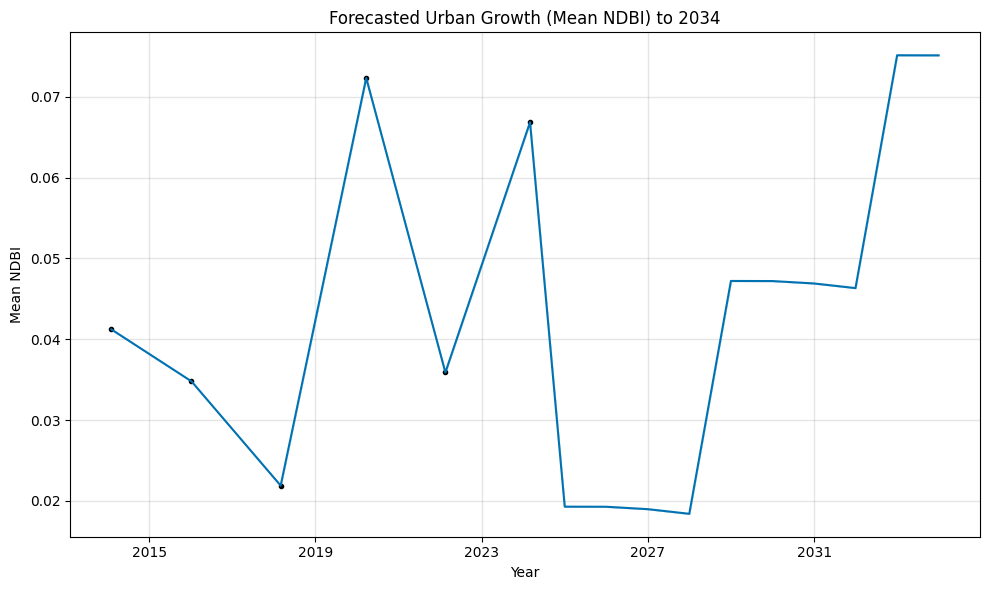

In [16]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Use your real dates and NDBI values here
df = pd.DataFrame(data)

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Forecasted Urban Growth (Mean NDBI) to 2034")
plt.xlabel("Year")
plt.ylabel("Mean NDBI")
plt.tight_layout()
plt.savefig("ndbi_forecast_2034.png", dpi=300)
plt.show()


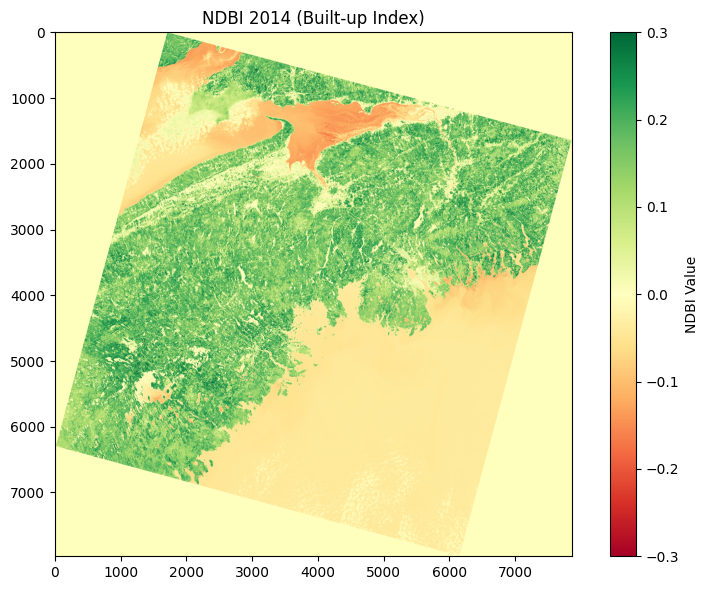

In [18]:


# Load bands and calculate NDBI
with rasterio.open("2014_B4.TIF") as b4, rasterio.open("2014_B5.TIF") as b5:
    nir = b4.read(1).astype("float32")
    swir = b5.read(1).astype("float32")
    ndbi = (swir - nir) / (swir + nir + 1e-6)

# Clip NDBI values to -1 to 1 for visualization
ndbi = np.clip(ndbi, -1, 1)

# Plot with good color scaling
plt.figure(figsize=(8, 6))
plt.imshow(ndbi, cmap='RdYlGn', vmin=-0.3, vmax=0.3)  # urban range focus
plt.title("NDBI 2014 (Built-up Index)")
plt.colorbar(label="NDBI Value")
plt.tight_layout()
plt.savefig("ndbi_2014_fixed.png", dpi=300)
plt.show()


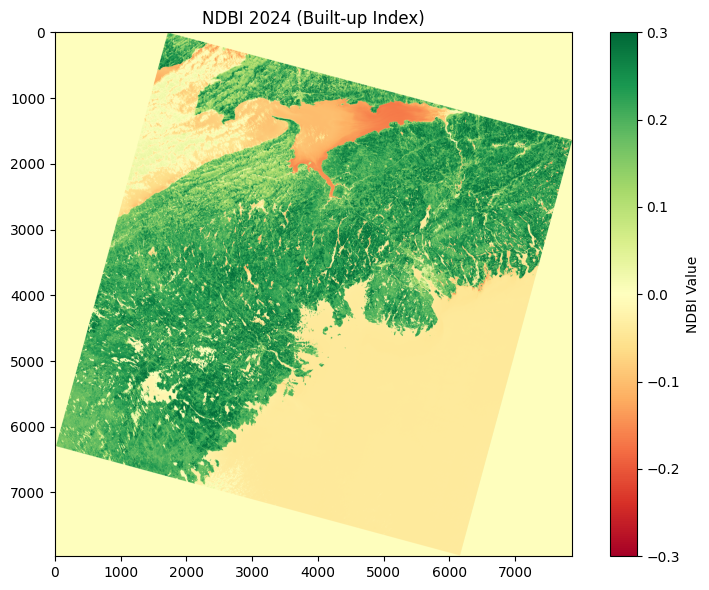

In [19]:
# Load bands and calculate NDBI
with rasterio.open("2024_B4n.TIF") as b4, rasterio.open("2024_B5n.TIF") as b5:
    nir = b4.read(1).astype("float32")
    swir = b5.read(1).astype("float32")
    ndbi = (swir - nir) / (swir + nir + 1e-6)

# Clip NDBI values to -1 to 1 for visualization
ndbi = np.clip(ndbi, -1, 1)

# Plot with good color scaling
plt.figure(figsize=(8, 6))
plt.imshow(ndbi, cmap='RdYlGn', vmin=-0.3, vmax=0.3)  # urban range focus
plt.title("NDBI 2024 (Built-up Index)")
plt.colorbar(label="NDBI Value")
plt.tight_layout()
plt.savefig("ndbi_2024_fixed.png", dpi=300)
plt.show()


In [21]:
from rasterio.warp import reproject, Resampling
import rasterio

def resample_raster(source_path, target_path, output_path):
    with rasterio.open(target_path) as ref:
        ref_profile = ref.profile
        ref_data = ref.read(1)

    with rasterio.open(source_path) as src:
        src_data = src.read(1)

        resampled = np.empty_like(ref_data, dtype='float32')

        reproject(
            source=src_data,
            destination=resampled,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref.transform,
            dst_crs=ref.crs,
            resampling=Resampling.bilinear
        )

    with rasterio.open(output_path, 'w', **ref_profile) as dst:
        dst.write(resampled, 1)

# Call it to resample 2023_B4 and B5
resample_raster("2024_B4n.TIF", "2014_B4.TIF", "2024_B4_resampled.TIF")
resample_raster("2024_B5n.TIF", "2014_B4.TIF", "2024_B5_resampled.TIF")


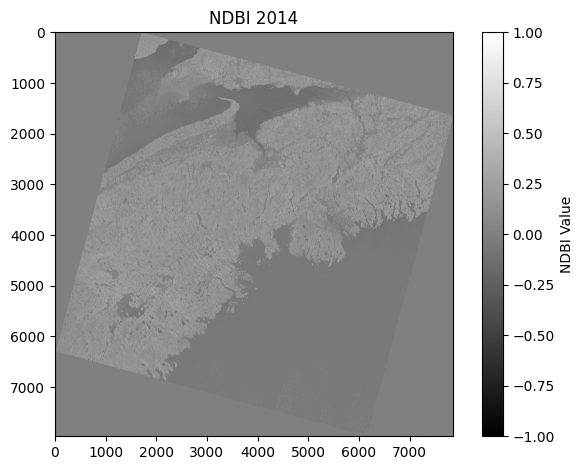

In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

b4_path = "2014_B4.TIF"  # update with correct file path
b5_path = "2014_B5.TIF"

def calculate_ndbi(b4_path, b5_path):
    with rasterio.open(b4_path) as nir, rasterio.open(b5_path) as swir:
        nir_data = nir.read(1).astype('float32')
        swir_data = swir.read(1).astype('float32')
        ndbi = (swir_data - nir_data) / (swir_data + nir_data + 1e-6)
        return ndbi

ndbi_2014 = calculate_ndbi(b4_path, b5_path)

plt.imshow(ndbi_2014, cmap='gray')
plt.title("NDBI 2014")
plt.colorbar(label="NDBI Value")
plt.tight_layout()
plt.savefig("ndbi_2014.png", dpi=300)
plt.show()


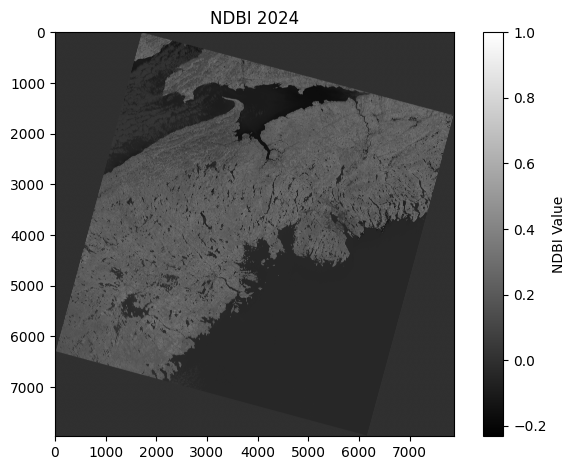

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

b4_path = "2024_B4n.TIF"  # update with correct file path
b5_path = "2024_B5n.TIF"

def calculate_ndbi(b4_path, b5_path):
    with rasterio.open(b4_path) as nir, rasterio.open(b5_path) as swir:
        nir_data = nir.read(1).astype('float32')
        swir_data = swir.read(1).astype('float32')
        ndbi = (swir_data - nir_data) / (swir_data + nir_data + 1e-6)
        return ndbi

ndbi_2024 = calculate_ndbi(b4_path, b5_path)

plt.imshow(ndbi_2024, cmap='gray')
plt.title("NDBI 2024")
plt.colorbar(label="NDBI Value")
plt.tight_layout()
plt.savefig("ndbi_2024.png", dpi=300)
plt.show()


In [24]:
ndbi_2024 = calculate_ndbi("2024_B4_resampled.TIF", "2024_B5_resampled.TIF")


In [25]:
ndbi_change = ndbi_2024 - ndbi_2014


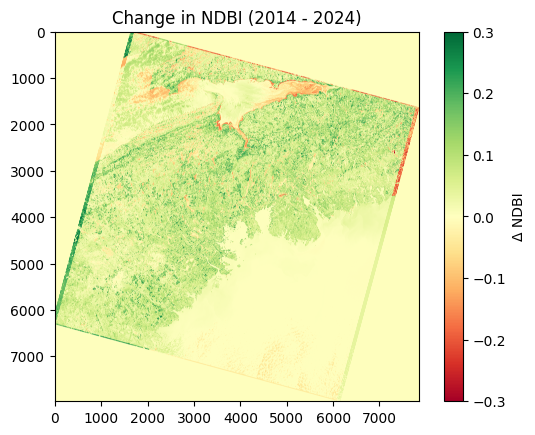

In [55]:
plt.imshow(ndbi_change, cmap='RdYlGn', vmin=-0.3, vmax=0.3)
plt.title("Change in NDBI (2014 - 2024)")
plt.colorbar(label="Δ NDBI")
plt.savefig("ndbi_change_final.png", dpi=300)
plt.show()


In [27]:
hotspots = np.where(ndbi_change > 0.1, 1, np.nan)

In [29]:
import rasterio
from rasterio.transform import from_origin

# Use your reference raster (e.g., one of the Landsat bands) to get metadata
with rasterio.open("2024_B4n.TIF") as src:
    meta = src.meta.copy()
    meta.update({
        "dtype": 'float32',
        "count": 1,
        "nodata": np.nan
    })

    with rasterio.open("hotspots.tif", "w", **meta) as dst:
        dst.write(hotspots.astype('float32'), 1)


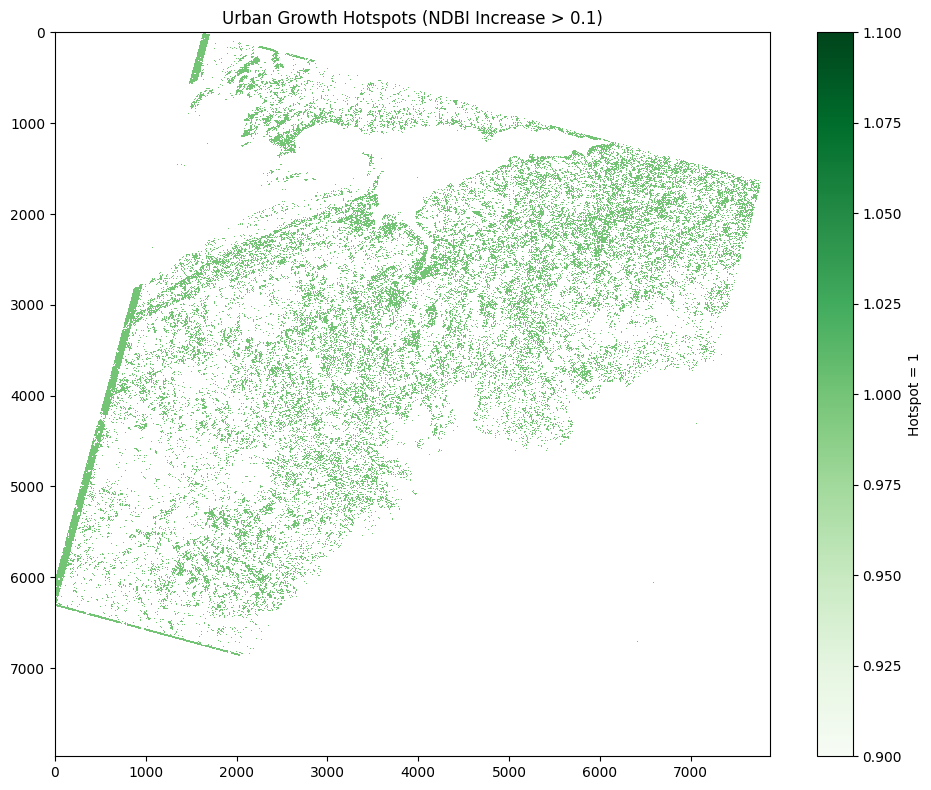

In [50]:
hotspot_data = np.where(hotspot_data == 1, 1, np.nan)  # enforce binary mask

plt.figure(figsize=(10, 8))
plt.imshow(hotspot_data, cmap='Greens', interpolation='nearest')
plt.title("Urban Growth Hotspots (NDBI Increase > 0.1)")
plt.colorbar(label='Hotspot = 1')
plt.tight_layout()
plt.savefig("hotspots_map_clean.png", dpi=300)
plt.show()


In [51]:
ndbi_change = ndbi_2024 - ndbi_2014
hotspots = np.where(ndbi_change > 0.1, 1, np.nan)


In [56]:
import folium
from folium.raster_layers import ImageOverlay

# You need bounds (lat/lon) for this to work
m = folium.Map(location=[44.65, -63.58], zoom_start=10)

# Assuming you have bounds, use ImageOverlay
ImageOverlay(
    image='ndbi_change_final.png',
      # example bounds
   bounds = [
    [43.50123, -65.61491],  # Lower Left
    [45.68591, -62.68280]   # Upper Right
],
    opacity=0.6
).add_to(m)

m.save("ndbi_map_overlayy.html")


In [53]:
import folium
from folium.raster_layers import ImageOverlay

# You need bounds (lat/lon) for this to work
m = folium.Map(location=[44.65, -63.58], zoom_start=10)

# Assuming you have bounds, use ImageOverlay
ImageOverlay(
    image='hotspots_map_clean.png',
      # example bounds
   bounds = [
    [43.50123, -65.61491],  # Lower Left
    [45.68591, -62.68280]   # Upper Right
],
    opacity=0.6
).add_to(m)

m.save("hotspotindexx.html")
